## JS Feature Selection, Exploratory Analysis

This notebook was made to develop different methods for transforming our dataset and applying feature selection. Some of the concepts from this notebook were used in the final pipeline and EPP_dataframe_maker and in the helper_functions.py file, including the RFE module and PCA module.


In [1]:
import pandas as pd
import numpy as np
from pandas import Series
#from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler    #scales all values to a range of 0 to 1 for better perform
from sklearn import linear_model
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.tree import DecisionTreeClassifier

# Garbage Collector
import gc

C:\Users\johns\AppData\Local\conda\conda\envs\data-x\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Moving Average

Applies moving average to dataset and plots for selection of the best moving average. Saves result as dfMA.

Consider changing the window types at a later date for weighting of values https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

In [2]:
# Last Semester Final Dataset (not MM scaled)
data=pd.read_csv('Retail Average Data Set.csv',index_col=0)    #index_col=0 prevents index from duplicating and forming unnamed column 0

# Toy dataset
#data=pd.read_csv('TOY DATA.csv',index_col=0) 

# JS Augmented dataset with capacity, EVs, and natural gas etc.
#data=pd.read_csv('FINAL DATA - FS 2018',index_col=0) 

#test=pd.read_csv('dfmmstest.csv',index_col=0)
data = data.reset_index(drop=True) 
data.head()
raw_price = data['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour']

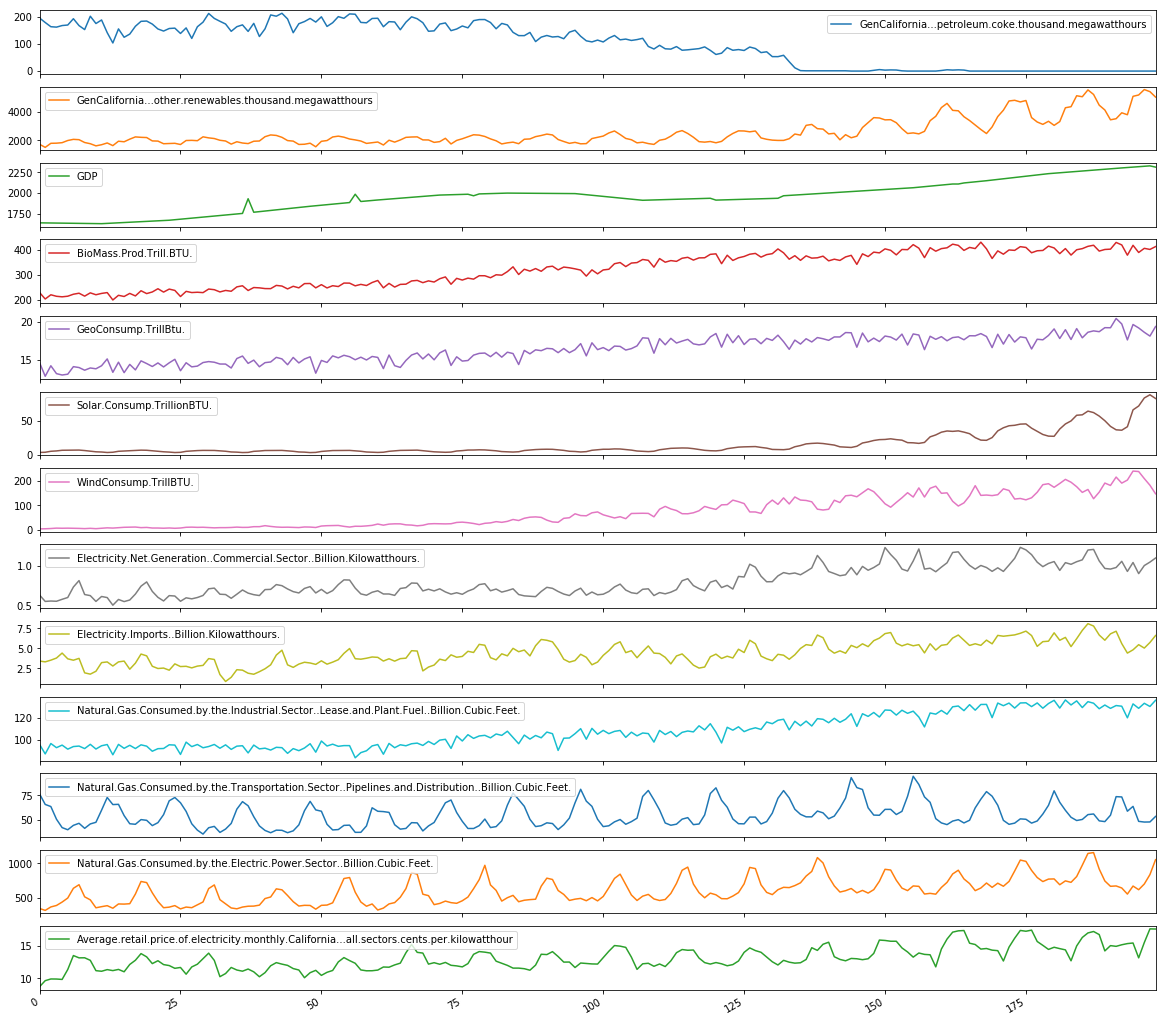

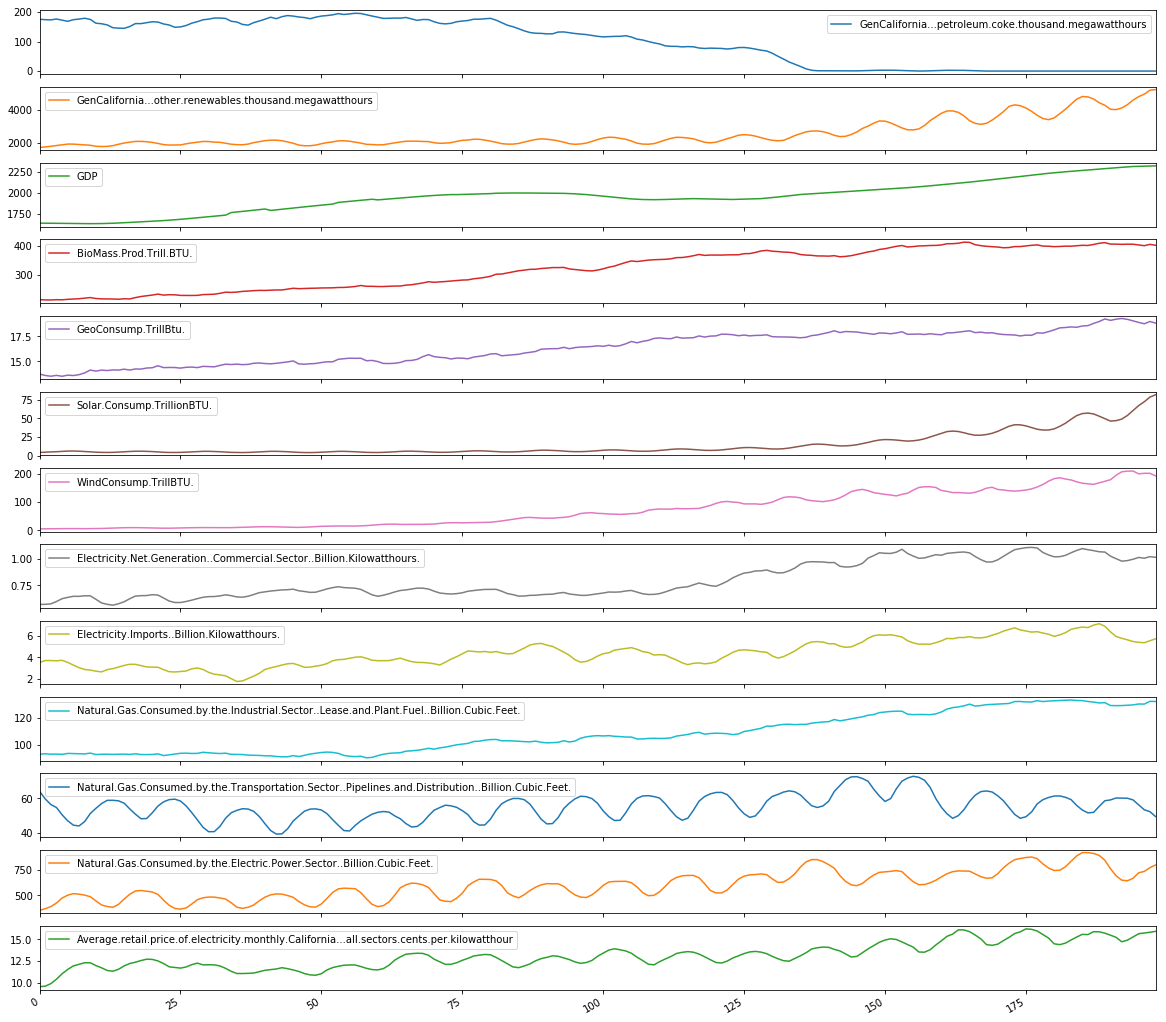

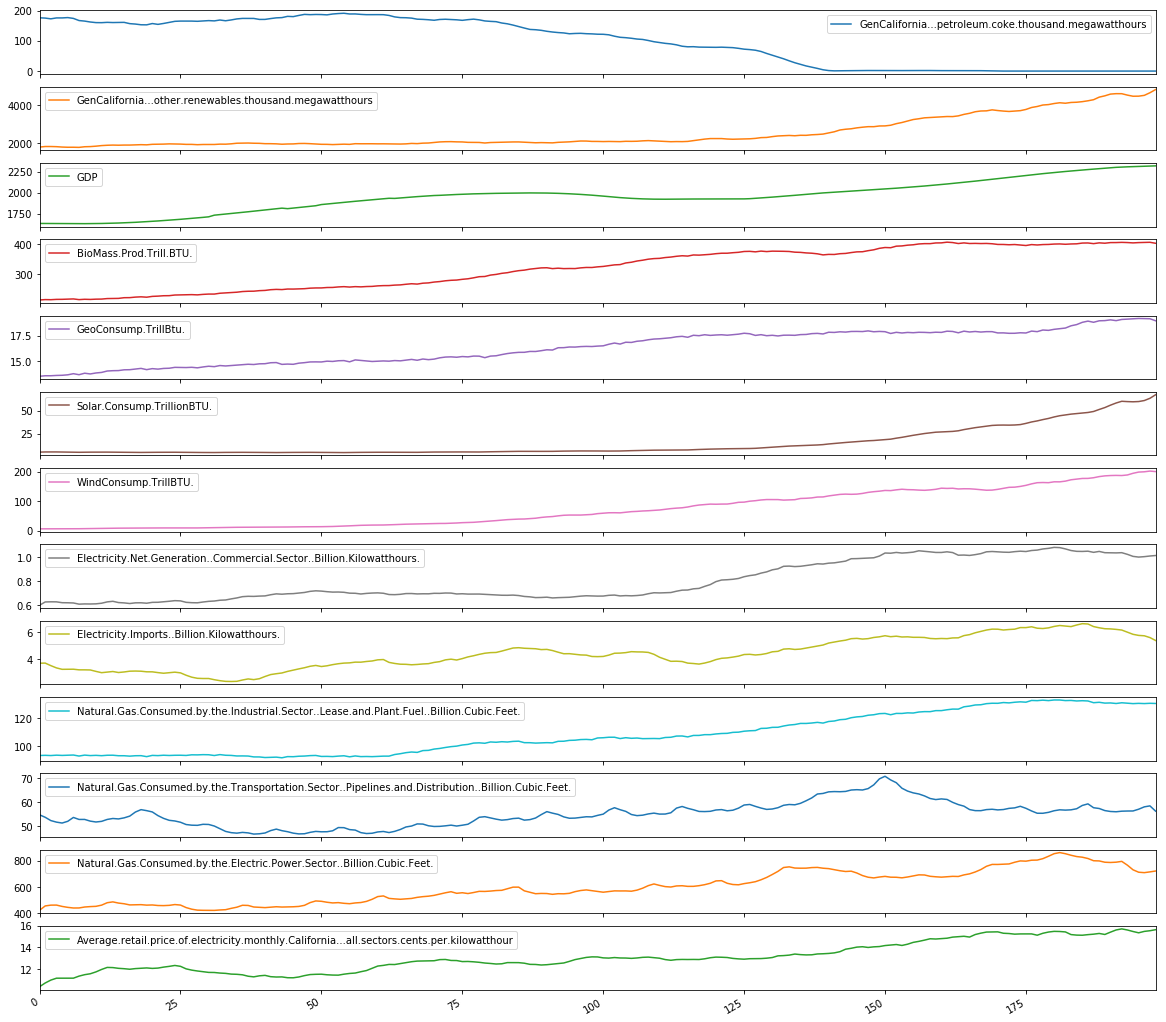

In [3]:
dfMA7 = data.rolling(window=7, min_periods=0,center=True).mean()
dfMA13 = data.rolling(window=13, min_periods=0,center=True).mean()


data.plot(subplots=True, figsize=(20, 20)); # Plotting Individual Columns
dfMA7.plot(subplots=True, figsize=(20, 20)); # Plotting Individual Columns
dfMA13.plot(subplots=True, figsize=(20, 20)); # Plotting Individual Columns

## Data Visualization
Visualize all features as scatter plots and line plots (source: EPPShikhar), apply the MatPlotLib intro notebook style facet plots to all data (Source: course material), apply correlation matrix from Project notebook (Static and Time based)

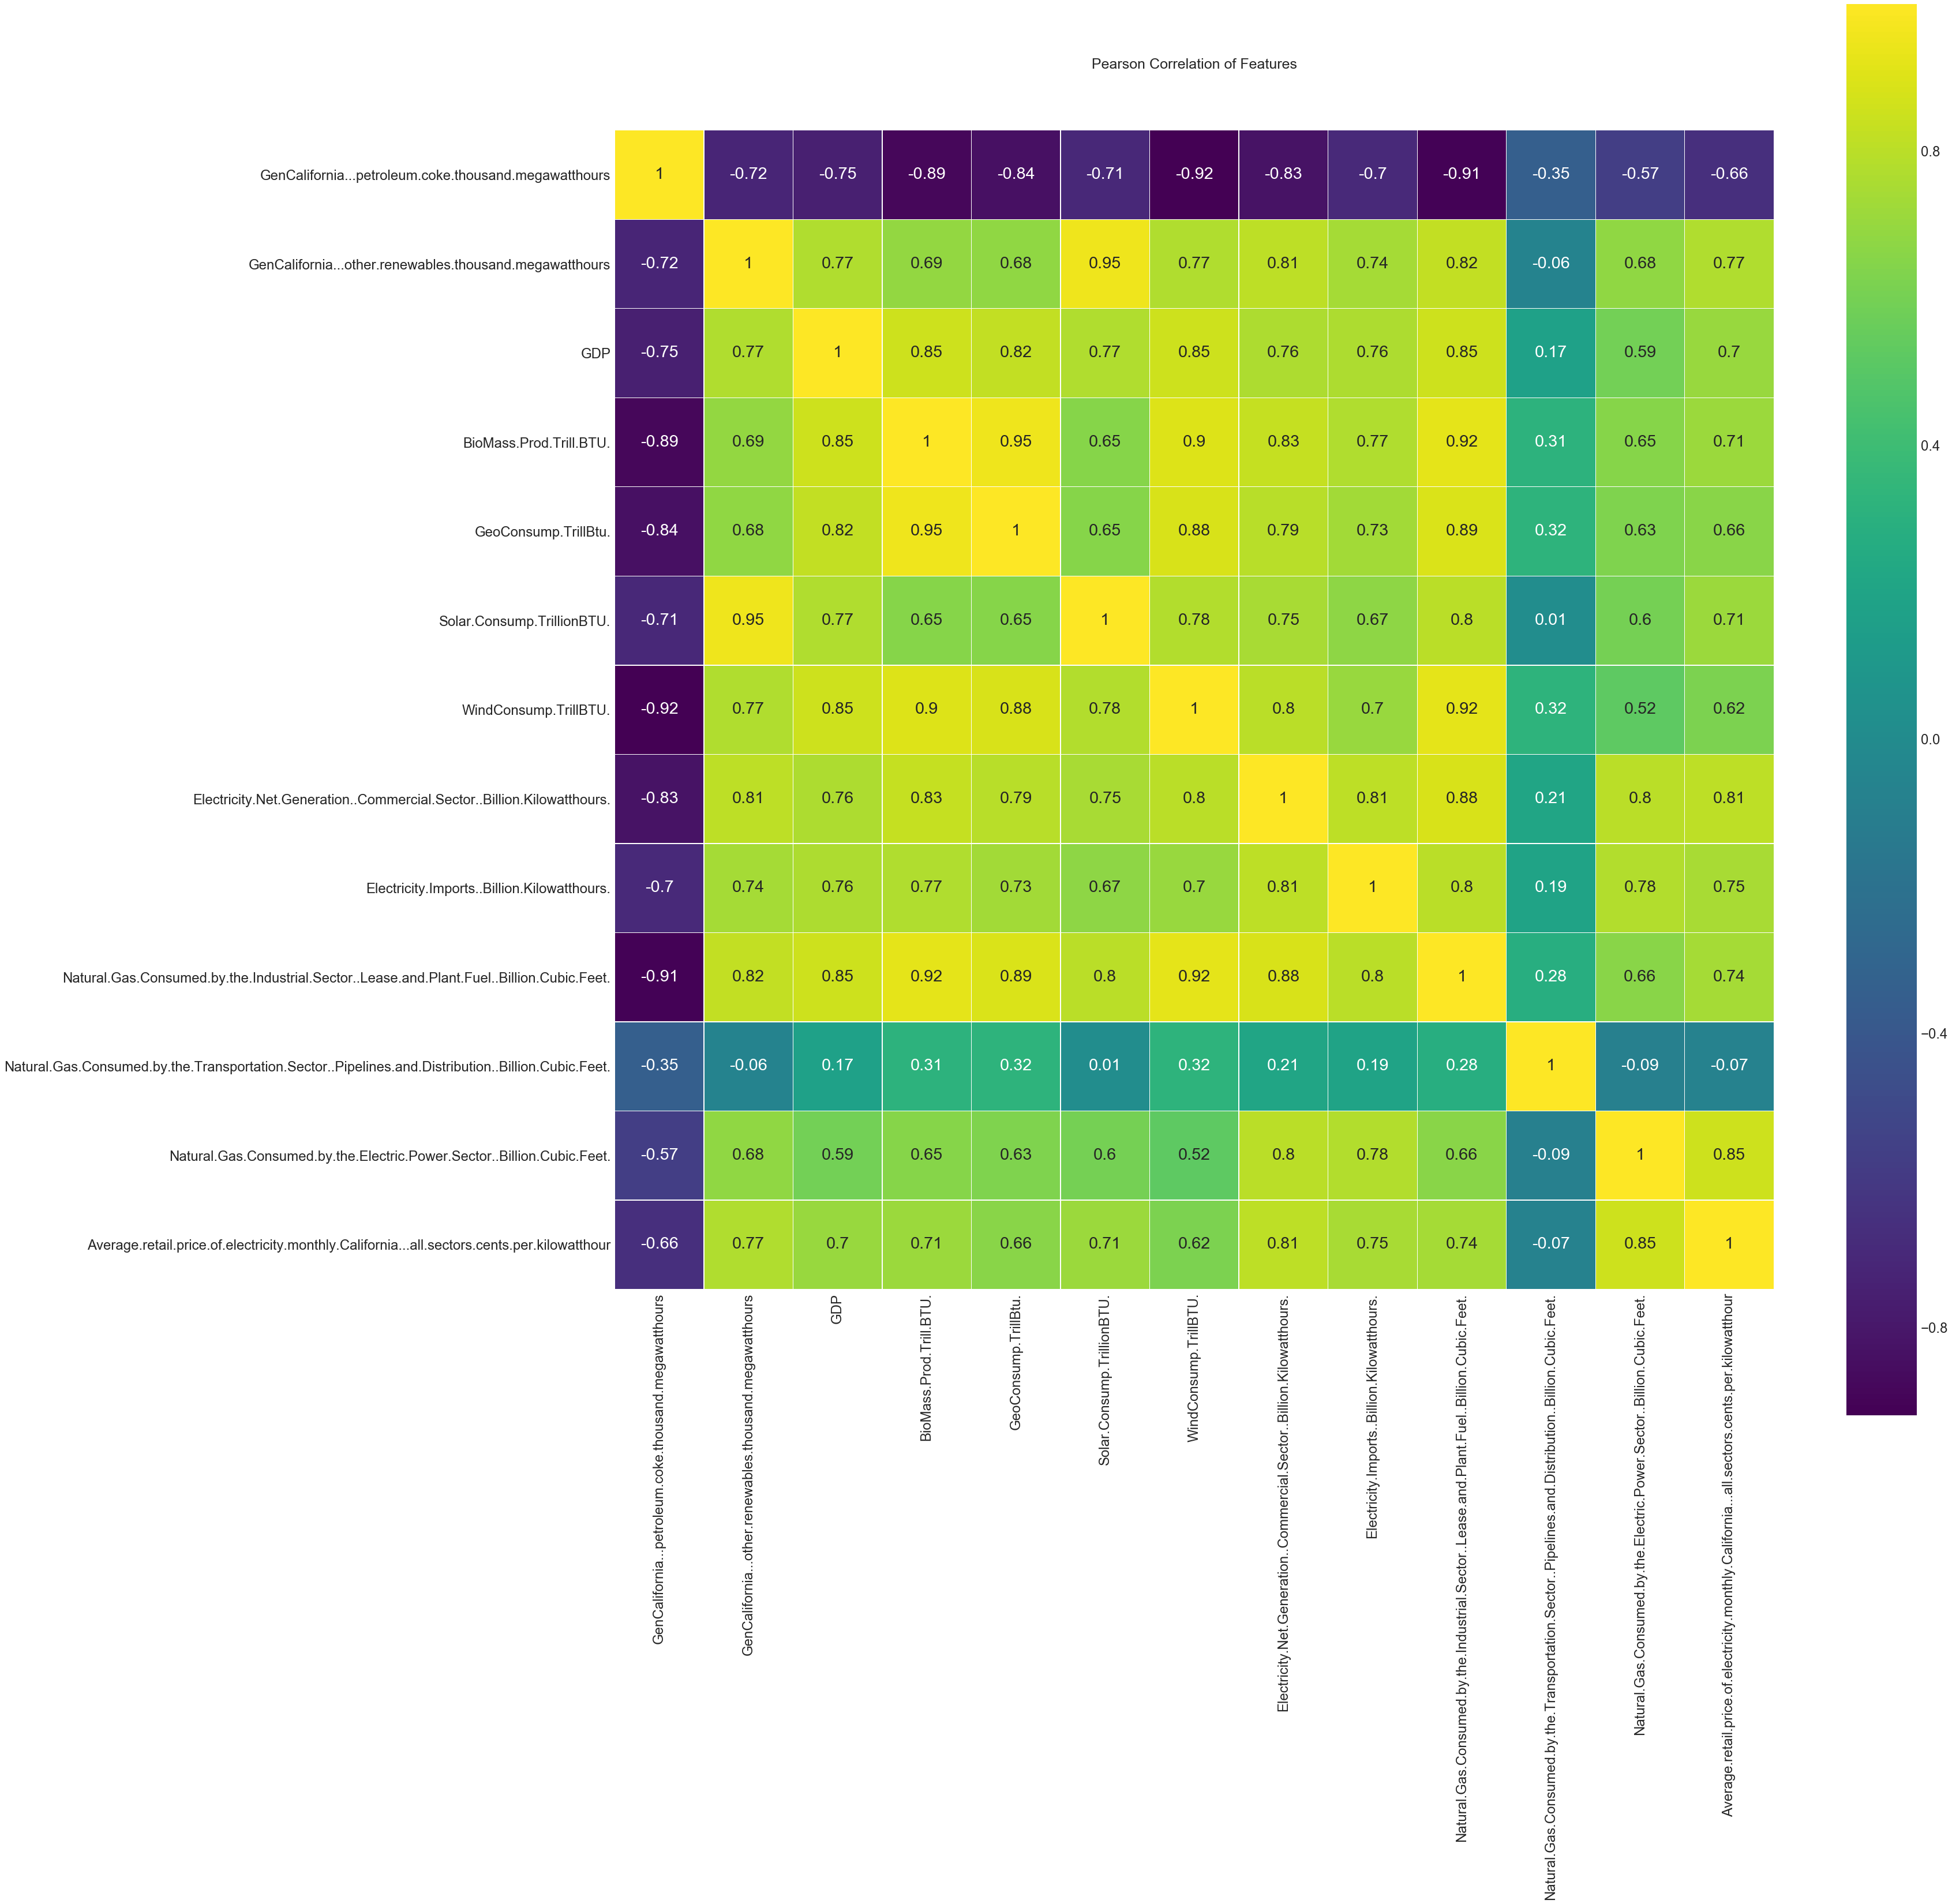

In [4]:
# Check correlation between features 
# (uncorrelated features are generally more powerful predictors)
colormap = plt.cm.viridis
sns.set(font_scale=2.4)
plt.figure(figsize=(45,45))
plt.title('Pearson Correlation of Features', y=1.05, size=25)
sns.heatmap(data.astype(float).corr().round(2)\
            ,linewidths=0.2,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

## Apply Transformations

Include the best of Eric's function transformations as well as derivatives and time lags. Also create transformations that makes price categorical for potential use in HMM and RFE algorithms.

In [5]:
data=pd.read_csv('Retail Average Data Set.csv',index_col=0)    #index_col=0 prevents index from duplicating and forming unnamed column 0
data = data.reset_index(drop=True) 

data['PriceBand'] = pd.cut(data['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour'], 15)
data[['PriceBand', 'Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour']].groupby(['PriceBand'], as_index=False)\
                    .mean().sort_values(by='PriceBand', ascending=True)  

PriceBand  \
0     (8.701, 9.299]   
1     (9.299, 9.889]   
2    (9.889, 10.478]   
3   (10.478, 11.067]   
4   (11.067, 11.657]   
5   (11.657, 12.246]   
6   (12.246, 12.835]   
7   (12.835, 13.425]   
8   (13.425, 14.014]   
9   (14.014, 14.603]   
10  (14.603, 15.193]   
11  (15.193, 15.782]   
12  (15.782, 16.371]   
13  (16.371, 16.961]   
14   (16.961, 17.55]   

    Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour  
0                                            8.710000                                            
1                                            9.776667                                            
2                                           10.176000                                            
3                                           10.847143                                            
4                                           11.335385                                            
5                                           12.012500                                            
6                                           12.503000                                            
7                                           13.102105                                            
8                                           13.795556                                            
9                                           14.291111                                            
10                                          14.891333                                            
11                                          15.494000                                            
12                                          16.047500                                            
13                                          16.805000                                            
14                                          17.298889

In [6]:
#make price categorical for use in feature selection algorithms. Currently uses 15 bins
raw_price_conversion = data['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour']

data['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour'] = pd.cut(data['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour'], 15,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]) 
#raw_price_conversion['PriceBand'] = data['PriceBand'].values
data = data.drop('PriceBand',axis=1)
data.head(20)

GenCalifornia...petroleum.coke.thousand.megawatthours  \
0                                             195.781       
1                                             179.294       
2                                             163.725       
3                                             162.202       
4                                             168.005       
5                                             169.982       
6                                             193.178       
7                                             167.782       
8                                             153.127       
9                                             202.481       
10                                            175.514       
11                                            188.579       
12                                            141.826       
13                                            103.712       
14                                            155.603       
15                                            124.751       
16                                            136.501       
17                                            165.366       
18                                            183.585       
19                                            184.674       

    GenCalifornia...other.renewables.thousand.megawatthours          GDP  \
0                                          1717.39841        1638.071284   
1                                          1504.66303        1637.154237   
2                                          1788.32478        1636.237190   
3                                          1797.49360        1635.320144   
4                                          1831.96794        1634.403097   
5                                          1982.97542        1633.486050   
6                                          2063.53758        1632.569004   
7                                          2040.64779        1631.651957   
8                                          1843.36061        1630.734910   
9                                          1759.08435        1629.817864   
10                                         1610.57418        1628.900817   
11                                         1689.58857        1627.983770   
12                                         1811.99852        1631.456110   
13                                         1626.95380        1634.930471   
14                                         1933.86384        1638.404832   
15                                         1895.40032        1641.879193   
16                                         2077.29368        1645.353554   
17                                         2234.09308        1648.827915   
18                                         2204.88500        1652.302276   
19                                         2189.71536        1655.776637   

    BioMass.Prod.Trill.BTU.  GeoConsump.TrillBtu.  Solar.Consump.TrillionBTU.  \
0                   228.434                14.612                       3.102   
1                   202.849                12.812                       3.401   
2                   219.649                14.206                       4.833   
3                   213.628                13.162                       5.368   
4                   211.506                12.980                       6.322   
5                   213.950                13.088                       6.476   
6                   221.842                14.087                       6.760   
7                   225.897                13.970                       6.630   
8                   214.229                13.617                       5.913   
9                   227.319                13.913                       4.994   
10                  219.773                13.805                       4.068   
11                  225.088                14.208                       3.763   
12                  228.396                15.114                       

In [7]:
raw_price_conversion.head()

0    8.71
1    9.63
2    9.89
3    9.88
4    9.82
Name: Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour, dtype: float64

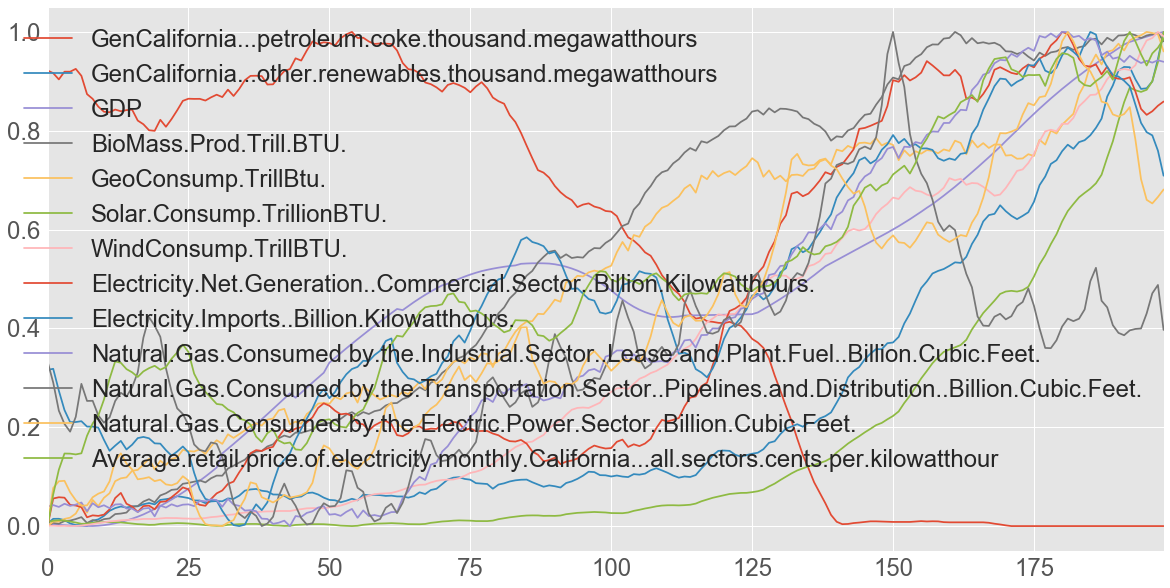

In [8]:
#apply Min Max scaler (to each smoothed dataframe)

plt.style.use('ggplot')

#this block trains all the models at once with a fit_transform
from sklearn.preprocessing import MinMaxScaler    #scales all values to a range of 0 to 1 for better performance

mms = MinMaxScaler()
#dfmms = pd.DataFrame(mms.fit_transform(data))
#dfmms.columns = data.columns
#dfmms.plot(figsize=(20, 20)); # Plotting Individual Columns

plt.figure
data_mms = pd.DataFrame(mms.fit_transform(data))
dfMA7_mms = pd.DataFrame(mms.fit_transform(dfMA7))
dfMA13_mms = pd.DataFrame(mms.fit_transform(dfMA13))
data_mms.columns = data.columns
dfMA7_mms.columns = data.columns
dfMA13_mms.columns = data.columns
dfMA13_mms.plot(figsize=(20, 10)); # Plotting Individual Columns

#mmstest = mms.fit_transform(X_val)
#ymmstrain = mms.fit_transform(Y_train)
#ymmstest = mms.fit_transform(Y_val)

#DataFrame(mmstrain)
#mmstrain = pd.DataFrame(mmstrain,index=mmstrain[:,0])
#mmstrain = mmstrain.reset_index(drop=True)
#mmstest = pd.DataFrame(mmstest,index=mmstest[:,0])
#mmstest = mmstest.reset_index(drop=True) 
#mmstrain
#logreg = LogisticRegression()

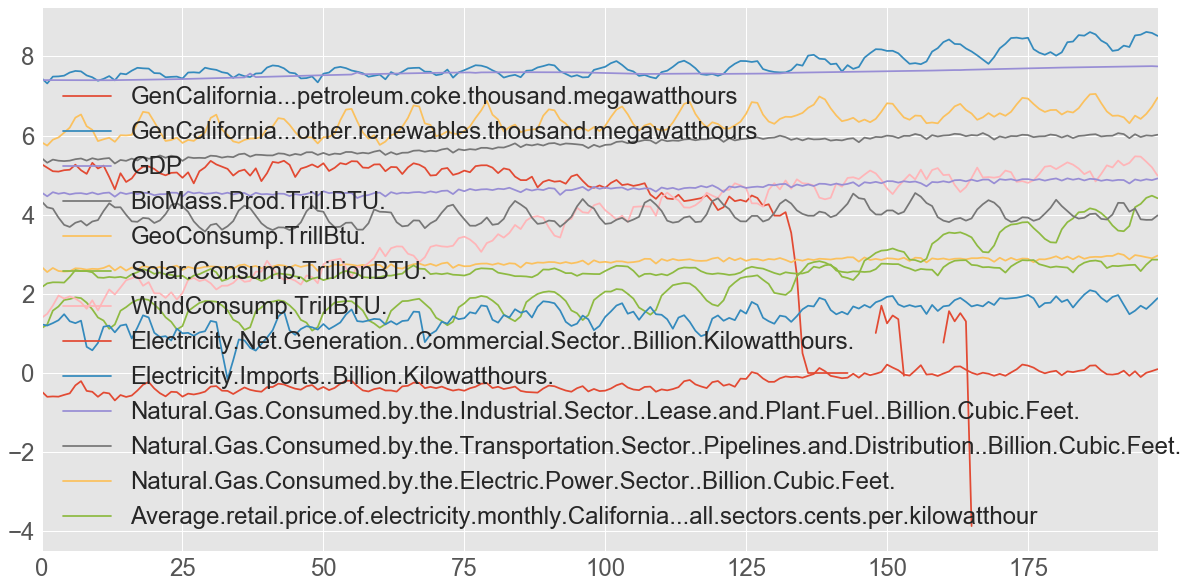

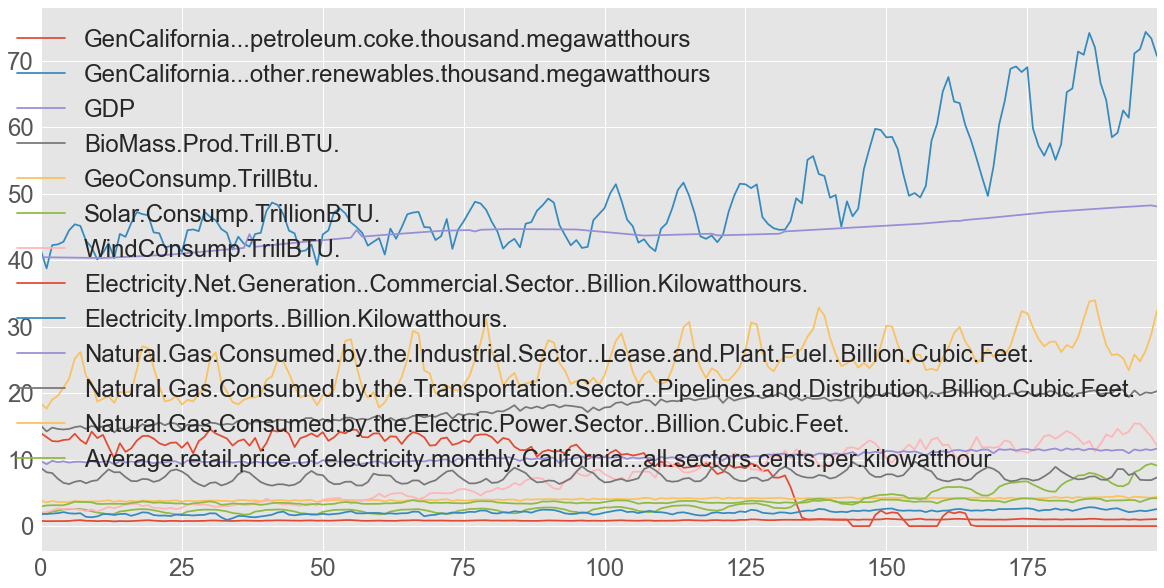

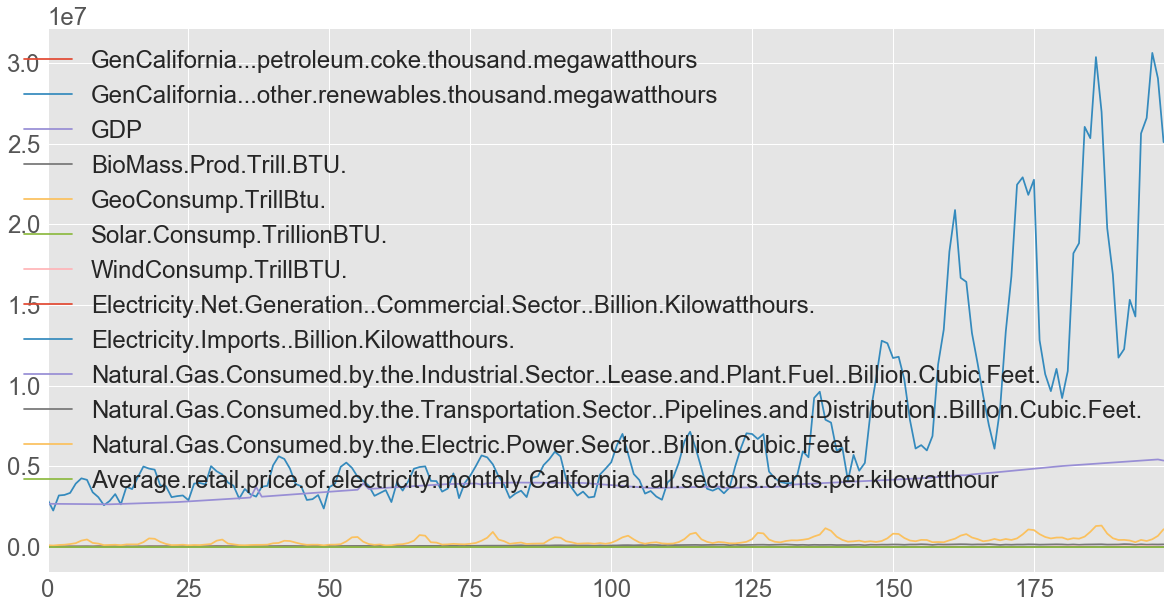

In [9]:
data=pd.read_csv('Retail Average Data Set.csv',index_col=0)    #index_col=0 prevents index from duplicating and forming unnamed column 0
data = data.reset_index(drop=True) 
#Apply functions
dataLOG = data.apply(np.log)
dataLOG.plot(figsize=(20, 10)); # Plotting Individual Columns

plt.figure
dataSQRT = data.apply(np.sqrt)
dataSQRT.plot(figsize=(20, 10)); # Plotting Individual Columns

plt.figure
dataSQ = data.apply(np.square)
dataSQ.plot(figsize=(20, 10)); # Plotting Individual Columns

In [12]:
#Apply derivatives to averaged data   (Only to smoothed dataframes)
dfMA7_D1 = dfMA7.diff(axis=0)
dfMA13_D1 = dfMA13.diff(axis=0)

dfMA7_D2 = dfMA7_D1.diff(axis=0)
dfMA13_D2 = dfMA13_D1.diff(axis=0)

#Apply derivatives to min max scaled averaged data   (Only to smoothed dataframes)
dfMA7_mms_D1 = dfMA7_mms.diff(axis=0)
dfMA13_mms_D1 = dfMA13_mms.diff(axis=0)

dfMA7_mms_D2 = dfMA7_mms_D1.diff(axis=0)
dfMA13_mms_D2 = dfMA13_mms_D1.diff(axis=0)

In [13]:
dfMA7_D2.head()

GenCalifornia...petroleum.coke.thousand.megawatthours  \
0                                                NaN       
1                                                NaN       
2                                           0.812533       
3                                           3.495590       
4                                          -6.858881       

   GenCalifornia...other.renewables.thousand.megawatthours           GDP  \
0                                                NaN                 NaN   
1                                                NaN                 NaN   
2                                          16.501381       -4.999993e-08   
3                                          -0.634257        1.142853e-07   
4                                           4.311761       -4.585234e-01   

   BioMass.Prod.Trill.BTU.  GeoConsump.TrillBtu.  Solar.Consump.TrillionBTU.  \
0                      NaN                   NaN                         NaN   
1                      NaN                   NaN                         NaN   
2                 0.716267              0.065867                   -0.117400   
3                 1.187581              0.164924                   -0.048514   
4                -1.339476             -0.178905                    0.240714   

   WindConsump.TrillBTU.  \
0                    NaN   
1                    NaN   
2              -0.027117   
3              -0.117638   
4               0.162333   

   Electricity.Net.Generation..Commercial.Sector..Billion.Kilowatthours.  \
0                                                NaN                       
1                                                NaN                       
2                                           0.003500                       
3                                           0.017857                       
4                                           0.004071                       

   Electricity.Imports..Billion.Kilowatthours.  \
0                                          NaN   
1                                          NaN   
2                                    -0.180383   
3                                    -0.024933   
4                                     0.072667   

   Natural.Gas.Consumed.by.the.Industrial.Sector..Lease.and.Plant.Fuel..Billion.Cubic.Feet.  \
0                                                NaN                                          
1                                                NaN                                          
2                                          -0.768183                                          
3                                           0.443895                                          
4                                          -0.315190                                          

   Natural.Gas.Consumed.by.the.Transportation.Sector..Pipelines.and.Distribution..Billion.Cubic.Feet.  \
0                                                NaN                                                    
1                                                NaN                                                    
2                                           1.093267                                                    
3                                           1.578152                                                    
4                                          -2.546976                                                    

   Natural.Gas.Consumed.by.the.Electric.Power.Sector..Billion.Cubic.Feet.  \
0                                                NaN                        
1                                                NaN                        
2                                           4.229000                        
3                                          14.232286                        
4                                          14.272143                        

   Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour  
0              

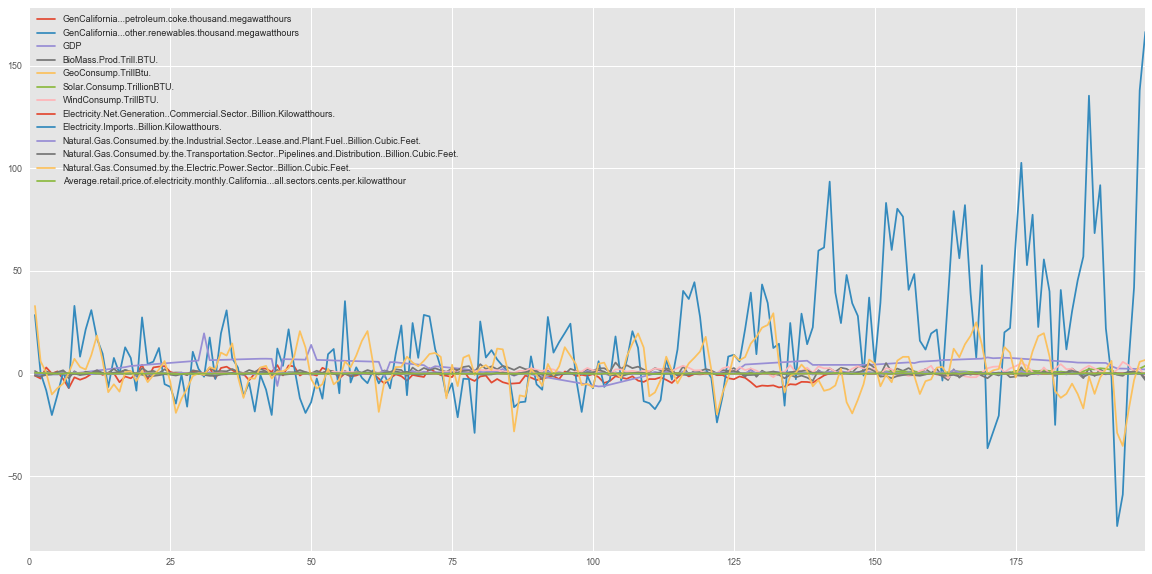

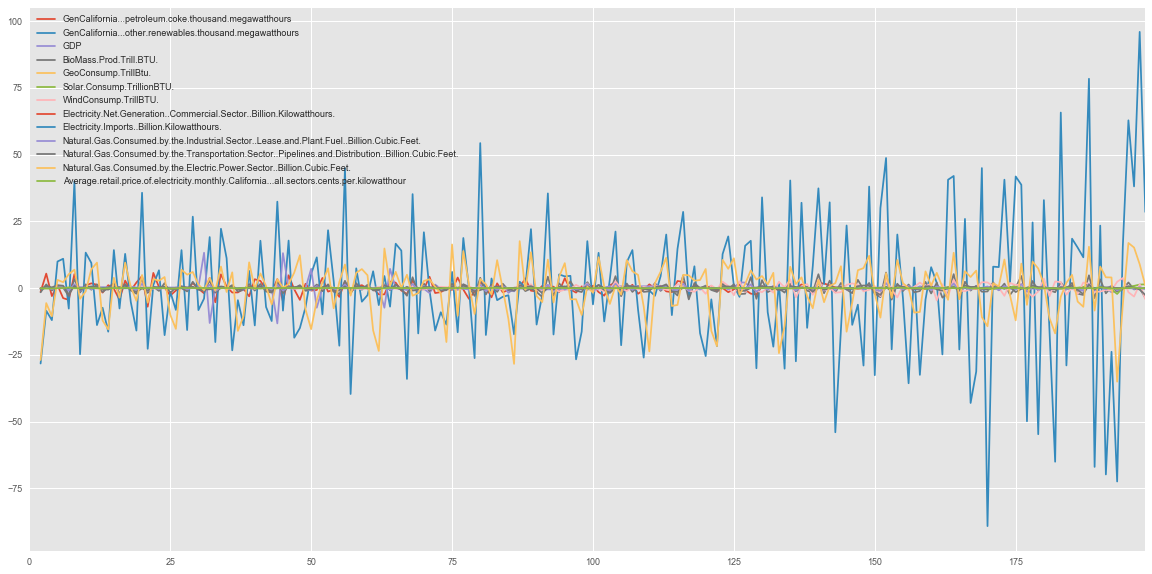

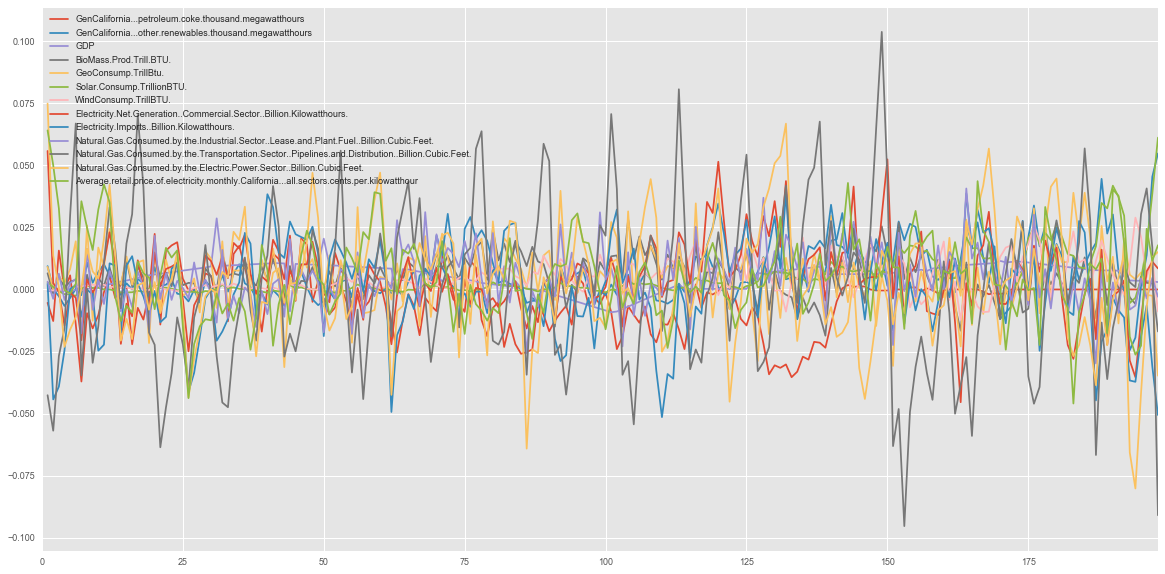

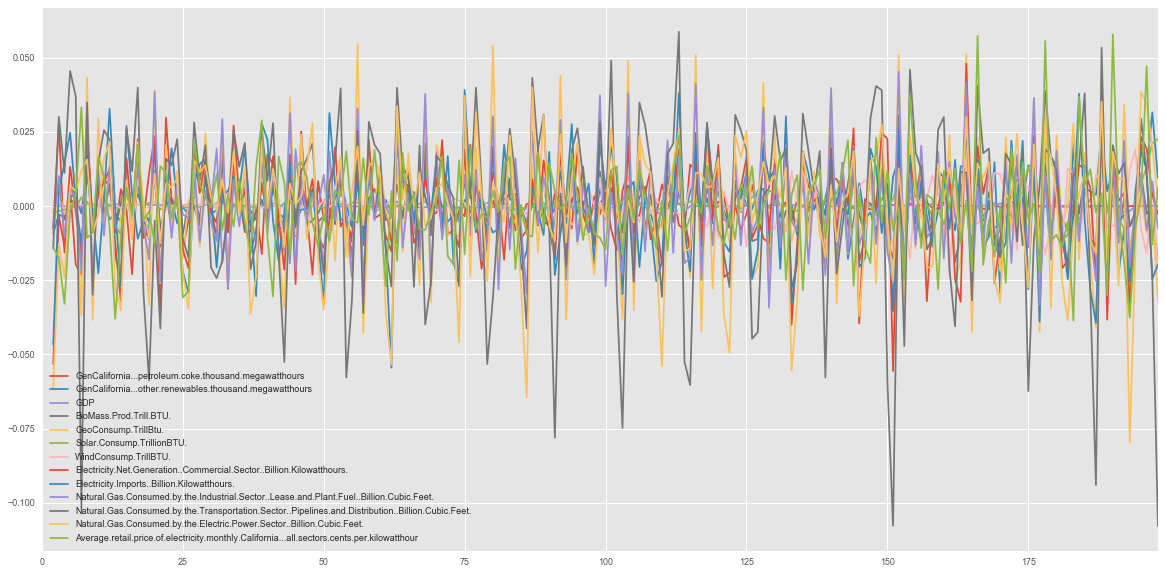

In [16]:
plt.figure
dfMA13_D1.plot(figsize=(20, 10)); # Plotting Individual Columns
plt.figure
dfMA13_D2.plot(figsize=(20, 10)); # Plotting Individual Columns
plt.figure
dfMA13_mms_D1.plot(figsize=(20, 10)); # Plotting Individual Columns
plt.figure
dfMA13_mms_D2.plot(figsize=(20, 10)); # Plotting Individual Columns

GenCalifornia...petroleum.coke.thousand.megawatthours  \
count                                         197.000000       
mean                                            0.000027       
std                                             0.010062       
min                                            -0.036549       
25%                                            -0.003721       
50%                                             0.000000       
75%                                             0.003276       
max                                             0.029805       

       GenCalifornia...other.renewables.thousand.megawatthours           GDP  \
count                                         197.000000        1.970000e+02   
mean                                            0.000231        1.856117e-05   
std                                             0.008776        3.213929e-03   
min                                            -0.029357       -1.933622e-02   
25%                                            -0.005176       -2.637784e-04   
50%                                            -0.000248        1.123821e-10   
75%                                             0.005473        2.476898e-04   
max                                             0.031599        1.935650e-02   

       BioMass.Prod.Trill.BTU.  GeoConsump.TrillBtu.  \
count               197.000000            197.000000   
mean                 -0.000119             -0.000223   
std                   0.010943              0.022004   
min                  -0.022718             -0.042758   
25%                  -0.007766             -0.014623   
50%                  -0.002990             -0.002840   
75%                   0.007869              0.015011   
max                   0.030627              0.054627   

       Solar.Consump.TrillionBTU.  WindConsump.TrillBTU.  \
count                  197.000000             197.000000   
mean                     0.000296              -0.000045   
std                      0.004505               0.006974   
min                     -0.035245              -0.023586   
25%                     -0.000781              -0.002531   
50%                     -0.000110              -0.000195   
75%                      0.001004               0.002343   
max                      0.022612               0.019179   

       Electricity.Net.Generation..Commercial.Sector..Billion.Kilowatthours.  \
count                                         197.000000                       
mean                                           -0.000240                       
std                                             0.015739                       
min                                            -0.055601                       
25%                                            -0.009690                       
50%                                             0.000635                       
75%                                             0.010167                       
max                                             0.047976                       

       Electricity.Imports..Billion.Kilowatthours.  \
count                                   197.000000   
mean                                     -0.000269   
std                                       0.017490   
min                                      -0.054488   
25%                                      -0.011862   
50%                                      -0.000194   
75%                                       0.012320   
max                                       0.039106   

       Natural.Gas.Consumed.by.the.Industrial.Sector..Lease.and.Plant.Fuel..Billion.Cubic.Feet.  \
count                                         197.000000                                          
mean                                           -0.000031                                          
std                                             0.017767                                          
min                                            -0.034262   

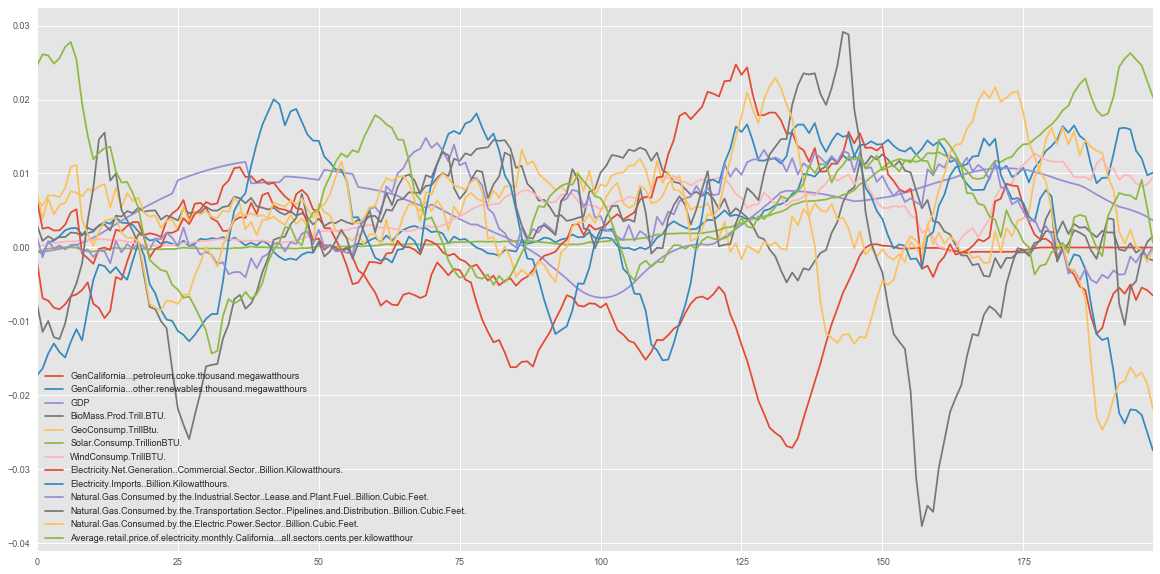

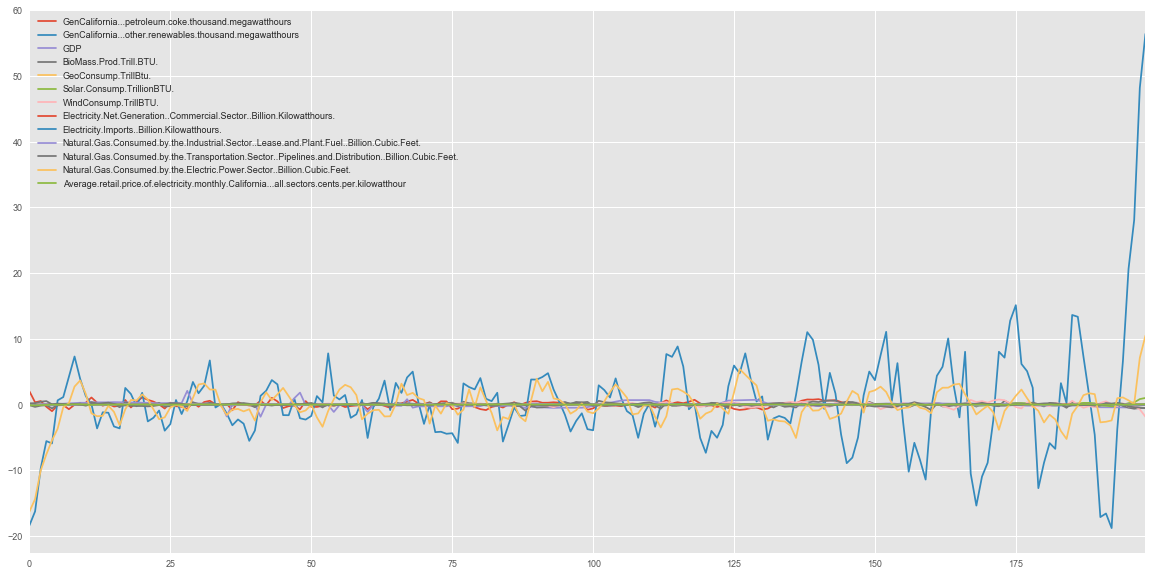

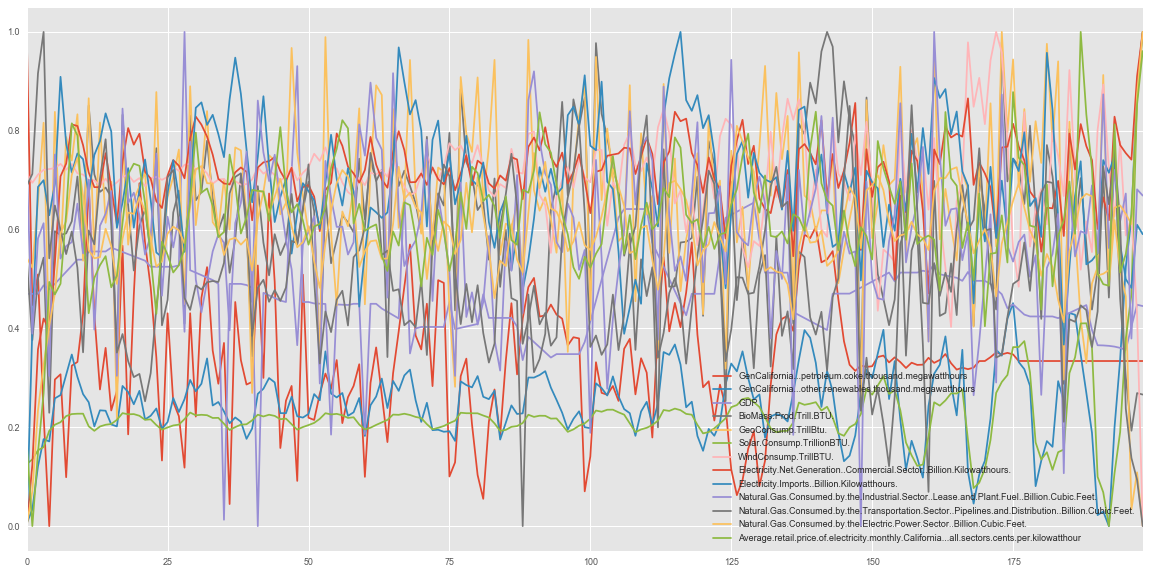

In [17]:
#potentially smooth the derivatives as well.
dfMA13_mms_D1_MA13 = dfMA13_mms_D1.rolling(window=13, min_periods=0,center=True).mean()
#dfMA13_mms_D2_MA25 = dfMA13_mms_D2.rolling(window=25, min_periods=0,center=True).mean()  #Looks like useless noise even after smoothing
#dfMA13_mms_D2_MA3 = dfMA13_mms_D2.rolling(window=3, min_periods=0,center=True).mean()
#dfMA13_D2_MA13 = dfMA13_D2.rolling(window=13, min_periods=0,center=True).mean() 
dfMA13_D2_MA7 = dfMA13_D2.rolling(window=7, min_periods=0,center=True).mean()
dfMA13_D2_MA7_mms = pd.DataFrame(mms.fit_transform(dfMA13_D2_MA7))
dfMA13_D2_MA7_mms.columns = data.columns


plt.figure
dfMA13_mms_D1_MA13.plot(figsize=(20, 10)); # Most structured D1 plot for EPP retail dataset

#plt.figure
#dfMA13_mms_D2_MA25.plot(figsize=(20, 10)); 
#plt.figure
#dfMA13_mms_D2_MA3.plot(figsize=(20, 10));
#plt.figure
#dfMA13_D2_MA13.plot(figsize=(20, 10)); 

plt.figure
dfMA13_D2_MA7.plot(figsize=(20, 10)); # Most Structured D2 plot for EPP retail dataset
plt.figure
dfMA13_D2_MA7_mms.plot(figsize=(20, 10)); #super noisy looking for EPP retail dataset


dfMA13_mms_D2.describe()

In [18]:
#Store final transformed datset

#dfMA13_mms_D1_MA13 = dfMA13_mms_D1_MA13.drop('Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour',axis=1)
#dataLOG = dataLOG.drop('Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour',axis=1)

df1 = pd.DataFrame()
df2 = pd.DataFrame()

col_names = list(dfMA13_mms_D1_MA13)
#rename values to be used in augmented dataframe
for col_name in col_names:
        df1[col_name+'_'+'MA13_mms_D1_MA13'] = dfMA13_mms_D1_MA13[col_name]

col_names = list(dataLOG)        
for col_name in col_names:
        df2[col_name+'_'+'Log'] = dataLOG[col_name]



#data = result = pd.concat([dfMA13_mms,df1,df2], axis=1, join_axes=[df1.index])
data = pd.concat([dfMA13_mms, df1], axis=1, join_axes=[df1.index])
data['PriceMA13'] = dfMA13['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour']
data['Raw Price'] = raw_price
data = data.rename(index=str, columns={'Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour': 'Price'})
#data = dfMA13_mms
#data = dataLOG
data.columns


Index(['GenCalifornia...petroleum.coke.thousand.megawatthours',
       'GenCalifornia...other.renewables.thousand.megawatthours', 'GDP',
       'BioMass.Prod.Trill.BTU.', 'GeoConsump.TrillBtu.',
       'Solar.Consump.TrillionBTU.', 'WindConsump.TrillBTU.',
       'Electricity.Net.Generation..Commercial.Sector..Billion.Kilowatthours.',
       'Electricity.Imports..Billion.Kilowatthours.',
       'Natural.Gas.Consumed.by.the.Industrial.Sector..Lease.and.Plant.Fuel..Billion.Cubic.Feet.',
       'Natural.Gas.Consumed.by.the.Transportation.Sector..Pipelines.and.Distribution..Billion.Cubic.Feet.',
       'Natural.Gas.Consumed.by.the.Electric.Power.Sector..Billion.Cubic.Feet.',
       'Price',
       'GenCalifornia...petroleum.coke.thousand.megawatthours_MA13_mms_D1_MA13',
       'GenCalifornia...other.renewables.thousand.megawatthours_MA13_mms_D1_MA13',
       'GDP_MA13_mms_D1_MA13', 'BioMass.Prod.Trill.BTU._MA13_mms_D1_MA13',
       'GeoConsump.TrillBtu._MA13_mms_D1_MA13',
       'Solar.Con

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, 0 to 198
Data columns (total 28 columns):
GenCalifornia...petroleum.coke.thousand.megawatthours                                                                  199 non-null float64
GenCalifornia...other.renewables.thousand.megawatthours                                                                199 non-null float64
GDP                                                                                                                    199 non-null float64
BioMass.Prod.Trill.BTU.                                                                                                199 non-null float64
GeoConsump.TrillBtu.                                                                                                   199 non-null float64
Solar.Consump.TrillionBTU.                                                                                             199 non-null float64
WindConsump.TrillBTU.                                       

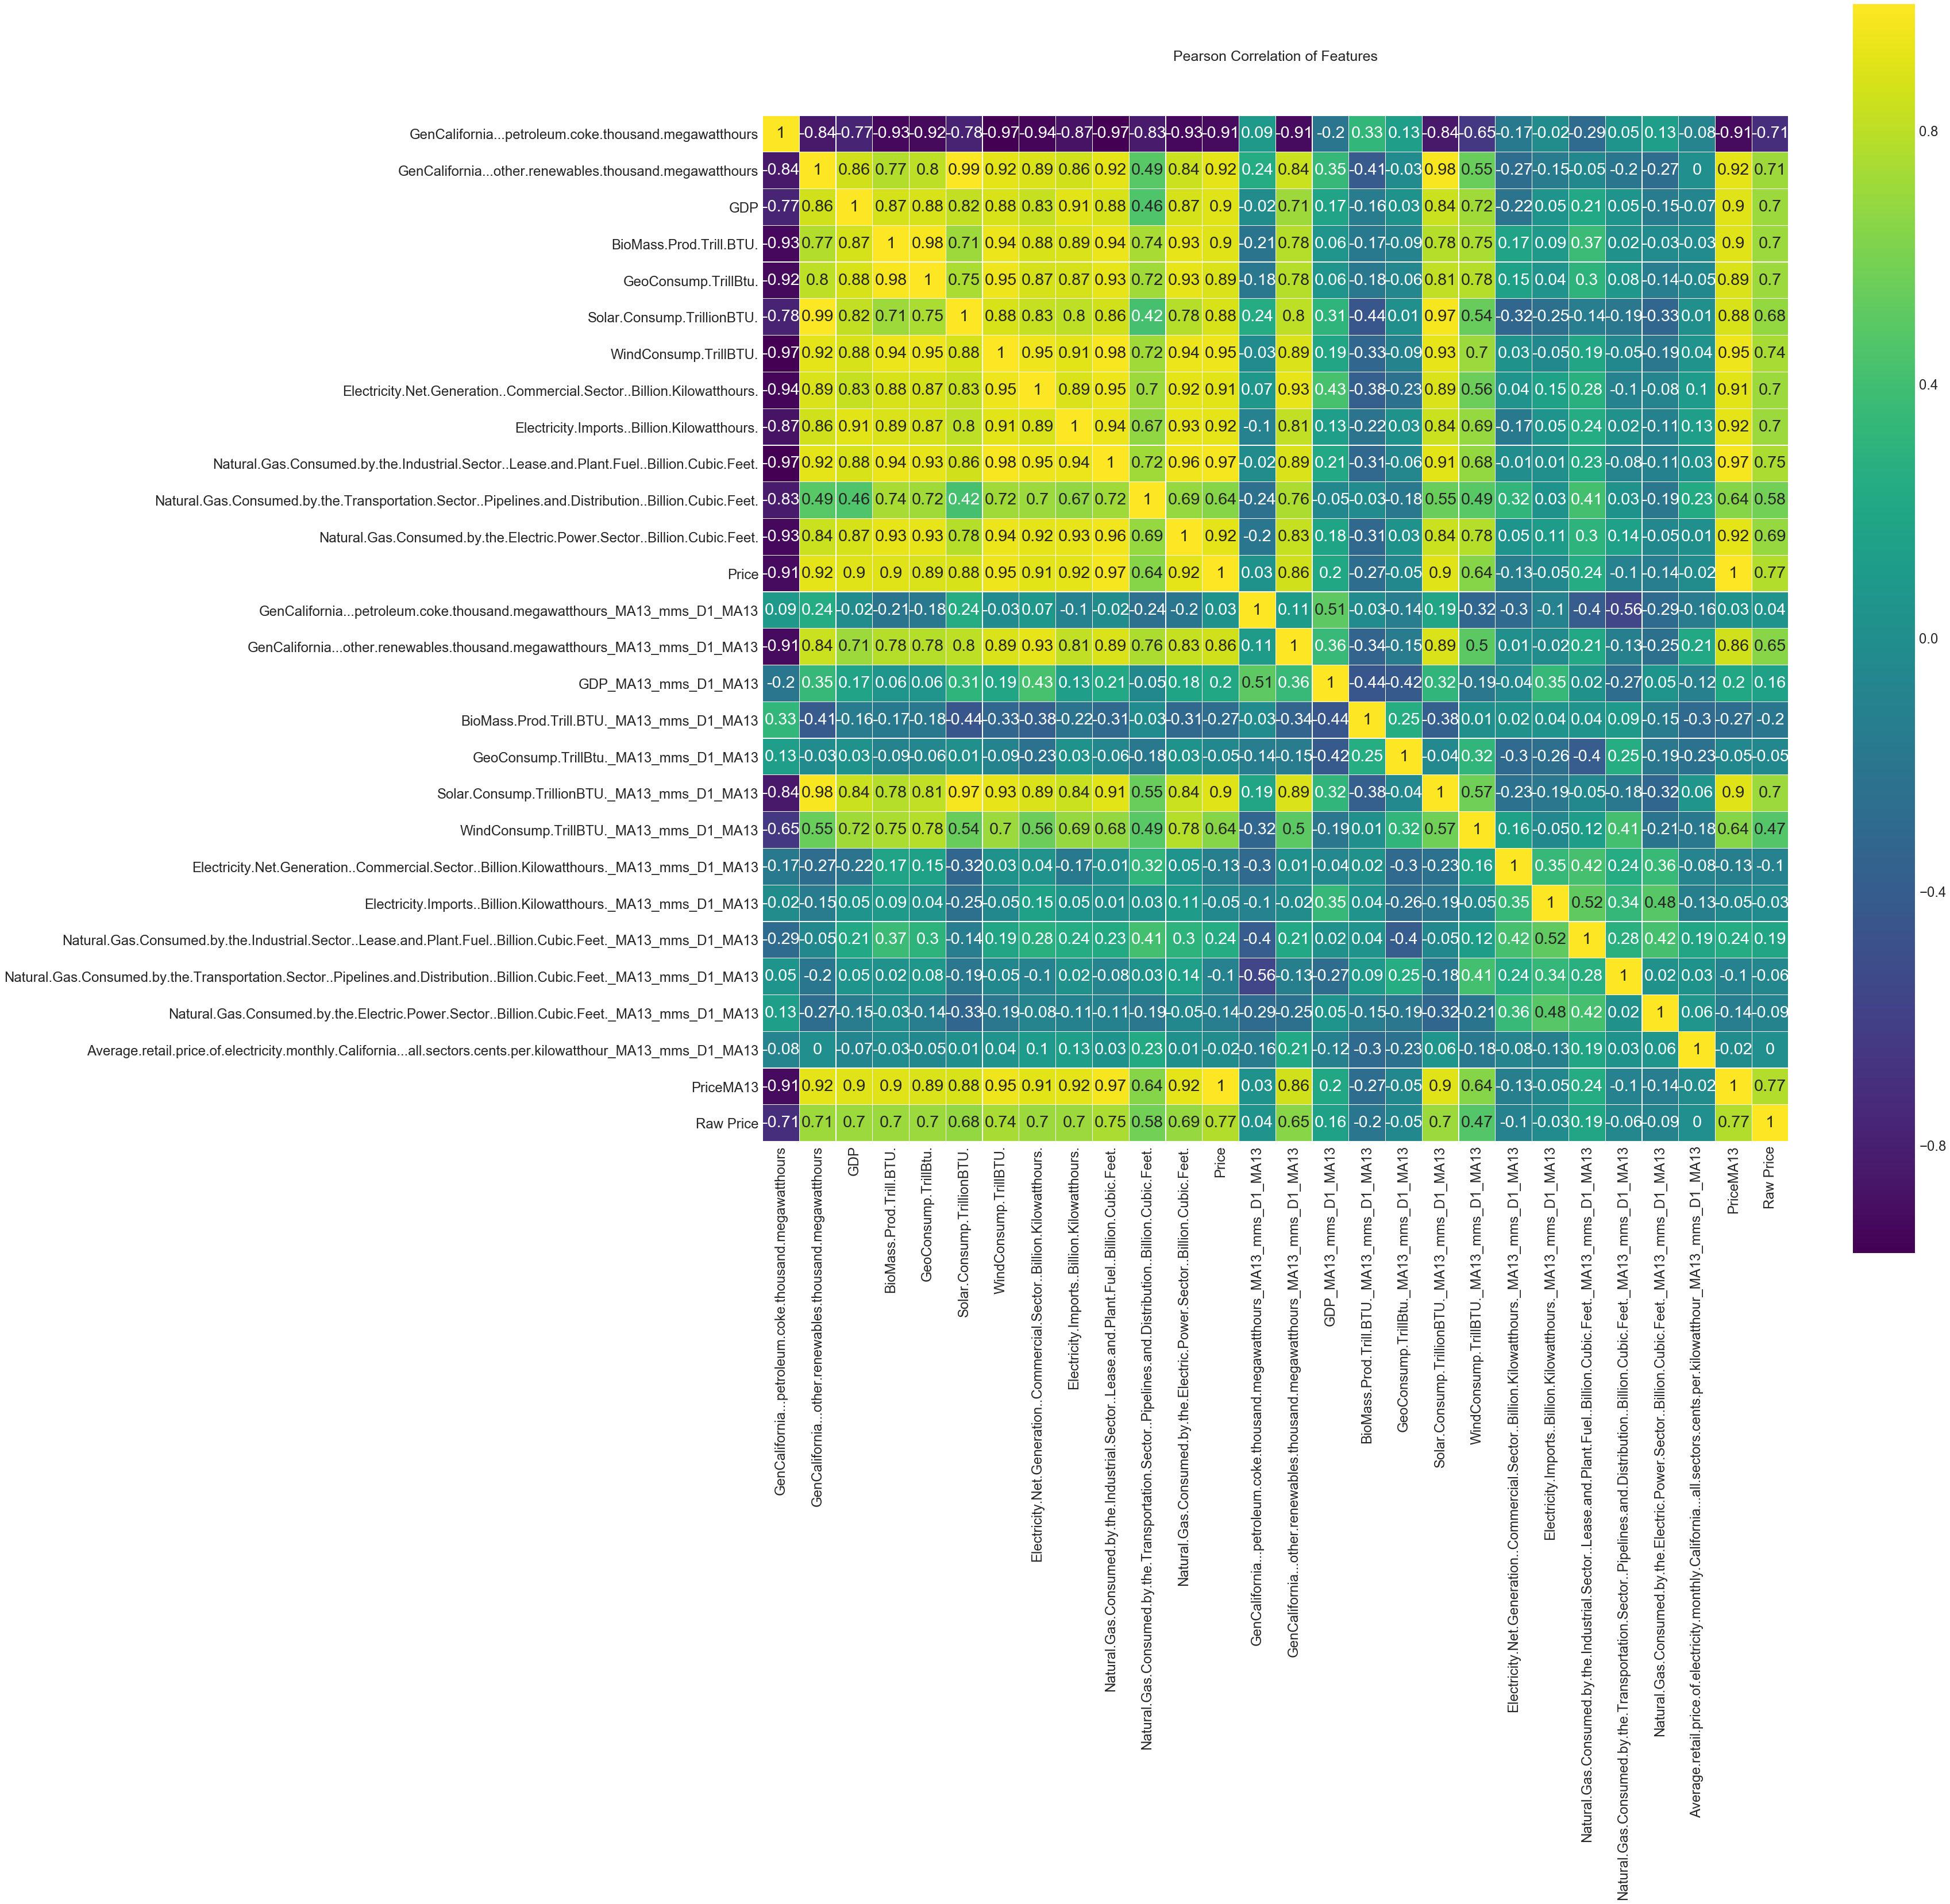

In [20]:
# Check correlation between features 
# (uncorrelated features are generally more powerful predictors)
colormap = plt.cm.viridis
sns.set(font_scale=2.4)
plt.figure(figsize=(40,40))
plt.title('Pearson Correlation of Features', y=1.05, size=25)
sns.heatmap(data.astype(float).corr().round(2)\
            ,linewidths=0.2,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

## Train Test Split

In [21]:
X = data.drop(['Price','PriceMA13','Raw Price'], axis=1) # Training & Validation data
Y = data['Price'] # Response / Target Variable  (smoothed scaled targets)

#X = data.drop(['Price','PriceMA13','Raw Price'], axis=1) # Training & Validation data
#Y = data['PriceMA13'] # Response / Target Variable  (smoothed NOT scaled targets)

#X = data.drop(['Price','PriceMA13','Raw Price'], axis=1) # Training & Validation data
#Y = data['Raw Price'] # Response / Target Variable  (raw price targets)


In [22]:
# For random mix of data

#np.random.seed(7)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.18, random_state=100)

print ('Number of samples in training data:',len(x_train))
print ('Number of samples in validation data:',len(x_test))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Number of samples in training data: 163
Number of samples in validation data: 36
(163, 25) (163,)
(36, 25) (36,)


In [23]:
#For a sequential train test split, testing on the last 3 years of data
x_train, x_test = X[0:len(X)-36], X[len(X)-36:]
y_train, y_test = Y[0:len(Y)-36], Y[len(Y)-36:]

print ('Number of samples in training data:',len(x_train))
print ('Number of samples in validation data:',len(x_test))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Number of samples in training data: 163
Number of samples in validation data: 36
(163, 25) (163,)
(36, 25) (36,)


## Feature selection algorithms

The first two examples use Iris data to show what output should look like (elimination, importance). Next 2 apply those to energy data. 

## Applying RFE to energy data

In [26]:
#Run RFE with linear SVR and 5 feature search
#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(x_train, y_train)
print(selector.support_) 
print(selector.ranking_)

[False  True False False  True  True False False False  True False  True
 False False False False False False False False False False False False
 False]
[ 4  1  3  6  1  1 12  5  2  1  8  1 17 16 18 15 21 20 19 11  9 14 13 10  7]


In [27]:
list(data.iloc[:,selector.support_]) #get the names of the 5 most important features

['GenCalifornia...other.renewables.thousand.megawatthours',
 'GeoConsump.TrillBtu.',
 'Solar.Consump.TrillionBTU.',
 'Natural.Gas.Consumed.by.the.Industrial.Sector..Lease.and.Plant.Fuel..Billion.Cubic.Feet.',
 'Natural.Gas.Consumed.by.the.Electric.Power.Sector..Billion.Cubic.Feet.']

In [32]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
 
#dataset = datasets.load_iris()
#X = boston["data"]
#Y = boston["target"]
#names = boston["feature_names"]
 
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,Y)
 
print ("Features sorted by their rank:")
print (zip(map(lambda x: round(x, 4), rfe.ranking_), col_names))
print(rfe)

Features sorted by their rank:
RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=1, step=1, verbose=0)


### PCA

PCA takes all features and compresses them down into equivalent features of lower dimensionality. All these features are compound features and have no intuitive meaning.

It outputs the relative importance of each transformed feature and the coefficients of the linear transformation to get from the original features to the transformed features

In [38]:
#https://machinelearningmastery.com/feature-selection-machine-learning-python/

# Feature Extraction with PCA
import numpy
from pandas import read_csv
from sklearn.decomposition import PCA
# load data
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dataframe = read_csv(url, names=names)
array = x_train.values
X = x_train.values
Y = y_train.values
# feature extraction
pca = PCA(n_components=5)
fit = pca.fit(X)
# summarize components
print("Explained Variance:",fit.explained_variance_ratio_)
print(fit.components_)



Explained Variance: [ 0.88384976  0.0541274   0.02698011  0.01892095  0.00763656]
[[ -4.21838126e-01   1.43494234e-01   1.96973983e-01   3.97090190e-01
    3.09356203e-01   9.90469702e-02   2.95849652e-01   3.27048610e-01
    2.41225941e-01   3.24996957e-01   2.64367101e-01   2.66746122e-01
   -3.99182415e-03   4.86158762e-03  -3.06528952e-04   4.57243350e-04
   -1.44796904e-03   4.21122158e-03   2.61768725e-03   4.53119621e-03
    3.70801592e-03   4.45798982e-03   1.78266072e-03  -4.95610988e-04
    1.64001609e-03]
 [ -3.90244359e-01   1.18374230e-01  -5.81596609e-01  -3.55116630e-01
   -2.69556347e-01   1.23941485e-01   6.03288814e-02   2.30463114e-01
   -1.87637264e-01   6.58194388e-02   4.10482381e-01  -1.22733423e-01
    1.25587966e-02   9.62815803e-03   7.78333715e-03  -8.53508719e-03
   -5.01460530e-03   4.76552160e-03  -6.46942661e-03   7.59176690e-03
   -1.33902785e-02  -5.66521388e-03  -2.00912740e-02  -1.25237482e-02
    1.25376446e-02]
 [ -2.17246198e-01  -3.08339711e-01  -

In [41]:
#https://machinelearningmastery.com/feature-selection-machine-learning-python/

# Feature Extraction with PCA

import numpy
from pandas import read_csv
from sklearn.decomposition import PCA


array = x_train.values
X = x_train.values
Y = y_train.values
# feature extraction
pca = PCA(n_components=5)
fit = pca.fit(X)
# summarize components
print("Explained Variance:",fit.explained_variance_ratio_)
print(fit.components_)


Explained Variance: [ 0.88384976  0.0541274   0.02698011  0.01892095  0.00763656]
[[ -4.21838126e-01   1.43494234e-01   1.96973983e-01   3.97090190e-01
    3.09356203e-01   9.90469702e-02   2.95849652e-01   3.27048610e-01
    2.41225941e-01   3.24996957e-01   2.64367101e-01   2.66746122e-01
   -3.99182415e-03   4.86158762e-03  -3.06528952e-04   4.57243350e-04
   -1.44796904e-03   4.21122158e-03   2.61768725e-03   4.53119621e-03
    3.70801592e-03   4.45798982e-03   1.78266072e-03  -4.95610988e-04
    1.64001609e-03]
 [ -3.90244359e-01   1.18374230e-01  -5.81596609e-01  -3.55116630e-01
   -2.69556347e-01   1.23941485e-01   6.03288814e-02   2.30463114e-01
   -1.87637264e-01   6.58194388e-02   4.10482381e-01  -1.22733423e-01
    1.25587966e-02   9.62815803e-03   7.78333715e-03  -8.53508719e-03
   -5.01460530e-03   4.76552160e-03  -6.46942661e-03   7.59176690e-03
   -1.33902785e-02  -5.66521388e-03  -2.00912740e-02  -1.25237482e-02
    1.25376446e-02]
 [ -2.17246198e-01  -3.08339711e-01  -

In [42]:
fit.components_

array([[ -4.21838126e-01,   1.43494234e-01,   1.96973983e-01,
          3.97090190e-01,   3.09356203e-01,   9.90469702e-02,
          2.95849652e-01,   3.27048610e-01,   2.41225941e-01,
          3.24996957e-01,   2.64367101e-01,   2.66746122e-01,
         -3.99182415e-03,   4.86158762e-03,  -3.06528952e-04,
          4.57243350e-04,  -1.44796904e-03,   4.21122158e-03,
          2.61768725e-03,   4.53119621e-03,   3.70801592e-03,
          4.45798982e-03,   1.78266072e-03,  -4.95610988e-04,
          1.64001609e-03],
       [ -3.90244359e-01,   1.18374230e-01,  -5.81596609e-01,
         -3.55116630e-01,  -2.69556347e-01,   1.23941485e-01,
          6.03288814e-02,   2.30463114e-01,  -1.87637264e-01,
          6.58194388e-02,   4.10482381e-01,  -1.22733423e-01,
          1.25587966e-02,   9.62815803e-03,   7.78333715e-03,
         -8.53508719e-03,  -5.01460530e-03,   4.76552160e-03,
         -6.46942661e-03,   7.59176690e-03,  -1.33902785e-02,
         -5.66521388e-03,  -2.00912740e-02,

In [48]:
#apply fit,components_ linear transformation to all data
fit.components_
print(fit.components_.shape)
#print(x_train.head())
#array = dataframe.values
#X = array[:,0:8]
#Y = array[:,8]


A = x_train.values #[:,0:len(x_train)]
print(A.shape)
B_train = np.matmul(A,fit.components_.T)

A = x_test.values #[:,0:len(x_train)]
print(A.shape)
B_test = np.matmul(A,fit.components_.T)

(5, 25)
(163, 25)
(36, 25)


In [50]:
#B_train #= Bdf.iloc[0:120]     #B is transformed data from PCA
#B_test #= Bdf.iloc[119:198]

X_train = B_train
Y_train = y_train #train['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour'] # Response / Target Variable
X_val = B_test
Y_val = y_test #test['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour'] # Response / Target Variable

np.random.seed(3) # set random seed for reproducibility

linreg = linear_model.LinearRegression() # instantiate
linreg.fit(X_train, Y_train) # fit
Y_train_pred = linreg.predict(X_train) # predict training labels
Y_pred = linreg.predict(X_val) # predict testing labels
acc_lin_train = round(linreg.score(X_train, Y_train) * 100, 2) # evaluate
acc_lin = round(linreg.score(X_val, Y_val) * 100, 2) # evaluate
#print('Training Accuracy =', acc_lin_train, '%')
#print('Testing Accuracy =', acc_lin, '%')

# The coefficients
print('Coefficients:', linreg.coef_)

# The mean squared error
TrainAllData = math.sqrt(mean_squared_error(Y_train, Y_train_pred))
TestAllData = math.sqrt(mean_squared_error(Y_val, Y_pred))

print("Train RMSE:",TrainAllData)
print("Test RMSE:",TestAllData)

Coefficients: [ 0.20834343 -0.05441691 -0.08248603  0.11015553 -0.26863805]
Train RMSE: 0.06453324663957669
Test RMSE: 0.09400668897957895


# Bookmark - fix trainmo and fullmo for plotting

In [62]:
#concatenates series for plotting
train_mo = x_train.index.values.astype(int) +1
#print(train_mo)
test_mo = x_test.index.values.astype(int) + 2 #+len(X_train.index.values)
#print(test_mo)
Full_mo=np.concatenate((train_mo,test_mo),axis=0)
#print(Full_mo)

Full_Y = np.concatenate((y_train,y_test),axis=0)

In [79]:
'''
#plot Y_train concatenated with Y_val and Y_train_pred concatenated with Y vs index
plt.figure(figsize=(15,10))
plt.scatter(Full_mo, Full_Y,  color='red')
plt.plot(train_mo, Y_train_pred, color='blue',
         linewidth=3)
plt.plot(test_mo, Y_pred, color='green',
         linewidth=3)
plt.xlabel('Month (index)')
plt.ylabel('Average Retail Energy Price, not scaled')
plt.title('Logistic regression using MMS retail average dataset (reversed order)')
plt.xticks(())
plt.yticks(())

plt.show()'''

"\n#plot Y_train concatenated with Y_val and Y_train_pred concatenated with Y vs index\nplt.figure(figsize=(15,10))\nplt.scatter(Full_mo, Full_Y,  color='red')\nplt.plot(train_mo, Y_train_pred, color='blue',\n         linewidth=3)\nplt.plot(test_mo, Y_pred, color='green',\n         linewidth=3)\nplt.xlabel('Month (index)')\nplt.ylabel('Average Retail Energy Price, not scaled')\nplt.title('Logistic regression using MMS retail average dataset (reversed order)')\nplt.xticks(())\nplt.yticks(())\n\nplt.show()"

## Linear model, no scaling

In [80]:
data=pd.read_csv('Retail Average Data Set.csv',index_col=0)    #index_col=0 prevents index from duplicating and forming unnamed column 0
#test=pd.read_csv('dfmmstest.csv',index_col=0)
data = data.reset_index(drop=True) 

In [81]:
from sklearn import linear_model

from sklearn.model_selection import train_test_split

#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)
train = data.iloc[0:120]
test = data.iloc[119:198]
#train = Bdf.iloc[0:120]     #B is transformed data from PCA
#test = Bdf.iloc[119:198]

X_train = train.drop('Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour', axis=1) # Training & Validation data
Y_train = train['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour'] # Response / Target Variable
X_val = test.drop('Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour', axis=1) # Training & Validation data
Y_val = test['Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour'] # Response / Target Variable

#
np.random.seed(3) # set random seed for reproducibility



print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)


linreg = linear_model.LinearRegression() # instantiate
linreg.fit(X_train, Y_train) # fit
Y_train_pred = linreg.predict(X_train) # predict training labels
Y_pred = linreg.predict(X_val) # predict testing labels
acc_lin_train = round(linreg.score(X_train, Y_train) * 100, 2) # evaluate
acc_lin = round(linreg.score(X_val, Y_val) * 100, 2) # evaluate
print('Training Accuracy =', acc_lin_train, '%')
print('Testing Accuracy =', acc_lin, '%')

# The coefficients
print('Coefficients:', linreg.coef_)

from sklearn.metrics import mean_squared_error
from math import sqrt

# The mean squared error
TrainAllData = sqrt(mean_squared_error(Y_train, Y_train_pred))
TestAllData = sqrt(mean_squared_error(Y_val, Y_pred))

print("Train RMSE:",TrainAllData)
print("Test RMSE:",TestAllData)



(120, 12) (120,)
(79, 12) (79,)
Training Accuracy = 73.81 %
Testing Accuracy = -3638.38 %
Coefficients: [ -5.41863403e-03   1.40695992e-03   6.29259983e-04   1.81919369e-03
  -1.02777871e-01  -3.96475549e-01   7.53645921e-03  -3.59048303e+00
  -1.32101789e-01   1.22314898e-02  -2.42352975e-02   8.69092897e-03]
Train RMSE: 0.6291247681078447
Test RMSE: 9.57038612029513


In [82]:
#concatenates series for plotting
train_mo = X_train.index.values +1
#print(train_mo)
test_mo = X_val.index.values +2 #+len(X_train.index.values)
#print(test_mo)
Full_mo=np.concatenate((train_mo,test_mo),axis=0)
#print(Full_mo)


Full_Y = np.concatenate((Y_train,Y_val),axis=0)
#print(Full_Y)

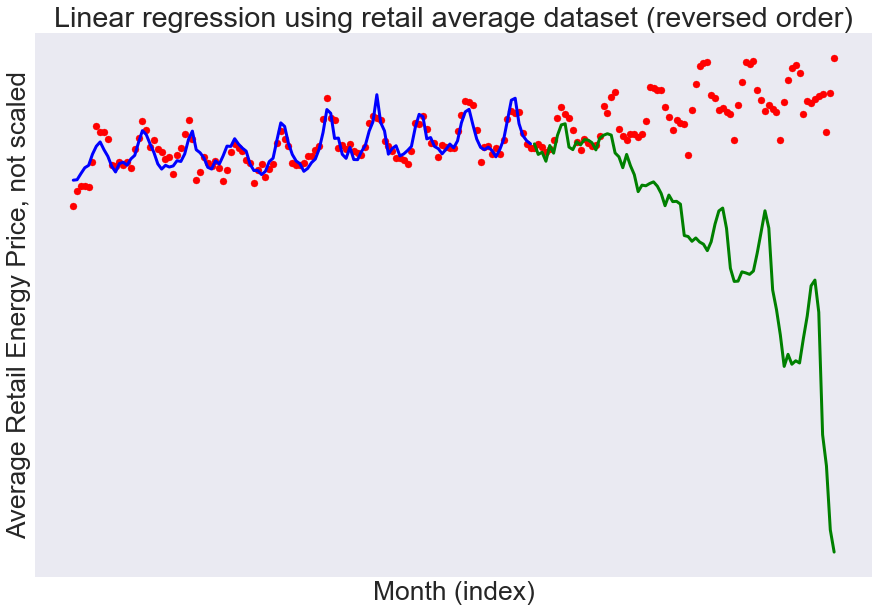

In [83]:
#plot Y_train concatenated with Y_val and Y_train_pred concatenated with Y vs index
plt.figure(figsize=(15,10))
plt.scatter(Full_mo, Full_Y,  color='red')
plt.plot(train_mo, Y_train_pred, color='blue',
         linewidth=3)
plt.plot(test_mo, Y_pred, color='green',
         linewidth=3)
plt.xlabel('Month (index)')
plt.ylabel('Average Retail Energy Price, not scaled')
plt.title('Linear regression using retail average dataset (reversed order)')
plt.xticks(())
plt.yticks(())

plt.show()

In [84]:
#this block trains all the models at once with a fit_transform
#reproduced above
from sklearn.preprocessing import MinMaxScaler    #scales all values to a range of 0 to 1 for better performance

mms = MinMaxScaler()
mmstrain = mms.fit_transform(X_train)
mmstest = mms.fit_transform(X_val)
#ymmstrain = mms.fit_transform(Y_train)
#ymmstest = mms.fit_transform(Y_val)
#DataFrame(mmstrain)
mmstrain = pd.DataFrame(mmstrain,index=mmstrain[:,0])
mmstrain = mmstrain.reset_index(drop=True)
mmstest = pd.DataFrame(mmstest,index=mmstest[:,0])
mmstest = mmstest.reset_index(drop=True) 
#mmstrain
#logreg = LogisticRegression()

In [85]:
np.random.seed(3) # set random seed for reproducibility

linreg.fit(mmstrain, Y_train) # fit
Y_train_pred = linreg.predict(mmstrain) # predict training labels
Y_pred = linreg.predict(mmstest) # predict testing labels
acc_lin_train = round(linreg.score(mmstrain, Y_train) * 100, 2) # evaluate
acc_lin = round(linreg.score(mmstest, Y_val) * 100, 2) # evaluate
print('Training Accuracy =', acc_lin_train, '%')
print('Testing Accuracy =', acc_lin, '%')

# The coefficients
print('Coefficients:', linreg.coef_)

# The mean squared error
TrainAllData = sqrt(mean_squared_error(Y_train, Y_train_pred))
TestAllData = sqrt(mean_squared_error(Y_val, Y_pred))

print("Train RMSE:",TrainAllData)
print("Test RMSE:",TestAllData)


Training Accuracy = 73.81 %
Testing Accuracy = 9.62 %
Coefficients: [-0.74201208  1.64363105  0.23367856  0.33097864 -0.5359866  -2.70039496
  0.68762654 -1.21358327 -0.69551592  0.38542647 -1.10251215  5.70637706]
Train RMSE: 0.6291247681078447
Test RMSE: 1.4880370752290386


In [86]:
Full_Y = np.concatenate((Y_train,Y_val),axis=0)

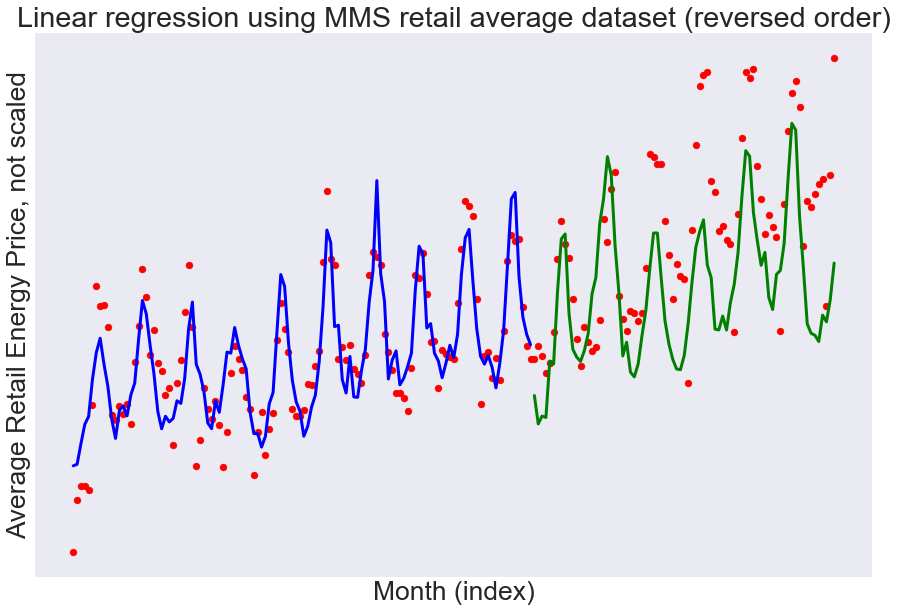

In [87]:
#plot Y_train concatenated with Y_val and Y_train_pred concatenated with Y vs index
plt.figure(figsize=(15,10))
plt.scatter(Full_mo, Full_Y,  color='red')
plt.plot(train_mo, Y_train_pred, color='blue',
         linewidth=3)
plt.plot(test_mo, Y_pred, color='green',
         linewidth=3)
plt.xlabel('Month (index)')
plt.ylabel('Average Retail Energy Price, not scaled')
plt.title('Linear regression using MMS retail average dataset (reversed order)')
plt.xticks(())
plt.yticks(())

plt.show()

In [88]:
from sklearn.linear_model import BayesianRidge  #still named ridge


np.random.seed(3) # set random seed for reproducibility

ridgereg = BayesianRidge()
ridgereg.fit(mmstrain, Y_train) # fit
Y_train_pred = ridgereg.predict(mmstrain) # predict training labels
Y_pred = ridgereg.predict(mmstest) # predict testing labels
acc_ridge_train = round(ridgereg.score(mmstrain, Y_train) * 100, 2) # evaluate
acc_ridge = round(ridgereg.score(mmstest, Y_val) * 100, 2) # evaluate
print('Training Accuracy =', acc_ridge_train, '%')
print('Testing Accuracy =', acc_ridge, '%')

# The coefficients
print('Coefficients:', ridgereg.coef_)

# The mean squared error
TrainAllData = sqrt(mean_squared_error(Y_train, Y_train_pred))
TestAllData = sqrt(mean_squared_error(Y_val, Y_pred))

print("Train RMSE:",TrainAllData)
print("Test RMSE:",TestAllData)

Training Accuracy = 72.77 %
Testing Accuracy = -38.87 %
Coefficients: [-0.64258442  0.90876092  0.40149215  0.20113479 -0.0947117  -0.80803626
 -0.09555381 -0.46349477 -0.48318624  0.25699913 -0.61931184  4.26919668]
Train RMSE: 0.6415317458216403
Test RMSE: 1.8445792758338382


In [89]:
Full_Y = np.concatenate((Y_train,Y_val),axis=0)

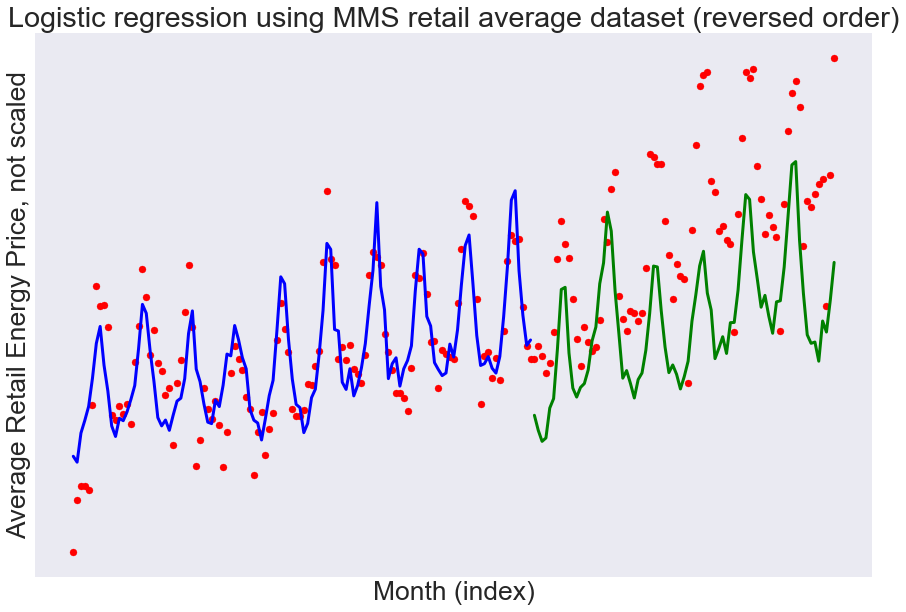

In [90]:
#plot Y_train concatenated with Y_val and Y_train_pred concatenated with Y vs index
plt.figure(figsize=(15,10))
plt.scatter(Full_mo, Full_Y,  color='red')
plt.plot(train_mo, Y_train_pred, color='blue',
         linewidth=3)
plt.plot(test_mo, Y_pred, color='green',
         linewidth=3)
plt.xlabel('Month (index)')
plt.ylabel('Average Retail Energy Price, not scaled')
plt.title('Logistic regression using MMS retail average dataset (reversed order)')
plt.xticks(())
plt.yticks(())

plt.show()

In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 13 columns):
GenCalifornia...petroleum.coke.thousand.megawatthours                                                 120 non-null float64
GenCalifornia...other.renewables.thousand.megawatthours                                               120 non-null float64
GDP                                                                                                   120 non-null float64
BioMass.Prod.Trill.BTU.                                                                               120 non-null float64
GeoConsump.TrillBtu.                                                                                  120 non-null float64
Solar.Consump.TrillionBTU.                                                                            120 non-null float64
WindConsump.TrillBTU.                                                                                 120 non-null float64
Electricity.Net.Generation..Commer